## Histogram of Oriented Gradients (HOG)
### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

First let's explore the vehicle and non vehicle data set. 

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import os
%matplotlib inline

In [2]:
def loadImages():
    vehicles = glob.glob('vehicles/*/**.png')
    non_vehicles = glob.glob('non-vehicles/*/**.png')
    return (vehicles, non_vehicles)

In [3]:
def convertFromCVtoMatlab(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Number of vehicle images: 8792, Number of non vehicle images 8968


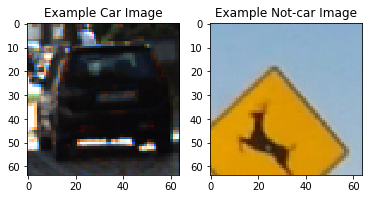

In [4]:

vehicles, non_vehicles = loadImages()

print("Number of vehicle images: {0}, Number of non vehicle images {1}".format(len(vehicles), len(non_vehicles)))

car_ind = np.random.randint(0, len(vehicles))
notcar_ind = np.random.randint(0, len(non_vehicles))

# Read in car / not-car images
car_image = cv2.imread(vehicles[car_ind])
notcar_image = cv2.imread(non_vehicles[notcar_ind])
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(convertFromCVtoMatlab(car_image))
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(convertFromCVtoMatlab(notcar_image))
plt.title('Example Not-car Image')


In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

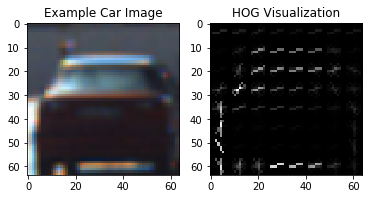

In [6]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicles))
# Read in the image
image = cv2.imread(vehicles[ind])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(convertFromCVtoMatlab(image), cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Take histograms in R, G, and B
    rhist = np.histogram(image[:,:,0], bins=nbins, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=nbins, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=nbins, range=(0, 256))
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return hist_features

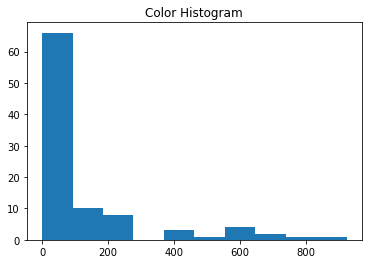

In [8]:
#Test color histogram
color_hist_feature = color_hist(image)
plt.hist(color_hist_feature)
plt.title('Color Histogram')
plt.show()

In [9]:
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel()
    

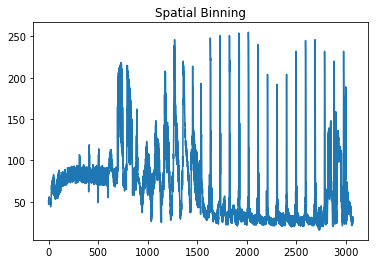

In [10]:
# Test spatial binning
spatial_bin_feature = bin_spatial(image)
plt.plot(spatial_bin_feature)
plt.title('Spatial Binning')
plt.show()

In [11]:
def single_img_features(image, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient =9, pix_per_cell = 8, 
                        cell_per_block = 2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    img_features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)      
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    img_features.append(spatial_features)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    img_features.append(hist_features)
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    img_features.append(hog_features)
    
    # Append the new feature vector to the features list
    return np.concatenate(img_features)


In [12]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient =9, pix_per_cell = 8, 
                        cell_per_block = 2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        img_features = single_img_features(image, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, hist_range=(0, 256),
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(img_features)
    
    return features
        

In [13]:

def train_model(vehicles, non_vehicles,fileName, colorspace='RGB', orient = 9, pix_per_cell = 8,cell_per_block = 2,hog_channel = 0,hist_bin = 32):
    
    filename_noextn, file_extension = os.path.splitext(fileName)
    scalerFileName =  filename_noextn + "scaler" + file_extension
    #Check if model eists
    if os.path.isfile(fileName):
        print("Model exists. Reloading from Disk")
        svc = joblib.load(fileName)
        XScaler = joblib.load(scalerFileName)
        return (svc, XScaler)
    
    t=time.time()
    car_features = extract_features(vehicles, colorspace, (32, 32),
                            hist_bin, (0, 256), orient, pix_per_cell, cell_per_block, hog_channel,
                            True, True, True)

    notcar_features = extract_features(non_vehicles, colorspace, (32, 32),
                            hist_bin, (0, 256),orient, pix_per_cell, cell_per_block, hog_channel,
                            True, True, True)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')

    # Define a labels vector based on features lists
    y = np.hstack((np.ones(len(car_features)), 
                  np.zeros(len(notcar_features))))

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)


    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    # Check the prediction time for a single
    t=time.time()
    n_predict = 10
    print('SVC predictions  : ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    #Save the model
    joblib.dump(svc, fileName) 
    joblib.dump(X_scaler, scalerFileName) 
    return (svc, X_scaler)

In [14]:
#Model training
colorspace='RGB' 
orient = 9 
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
hist_bin = 32
train_model(vehicles, non_vehicles, 'vehicle_non_vehicle.pkl', 'RGB', 9, 8, 2, 0, 32)

34.42 Seconds to extract features...
18.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9758
SVC predictions  :  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
0.00221 Seconds to predict 10 labels with SVC


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

#### Training results with 1 hog channel
35.46 Seconds to extract features...  
18.16 Seconds to train SVC...  
Test Accuracy of SVC =  0.9685  
SVC predictions  :  [ 0.  1.  0.  1.  0.  0.  1.  1.  1.  0.]  
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  0.]  
0.00238 Seconds to predict 10 labels with SVC  
Out[18]:  
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,  
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,  
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,  
     verbose=0)

In [15]:
colorspace='RGB' 
orient = 9 
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
hist_bin = 32
svcmodel, X_Scaler = train_model(vehicles, non_vehicles,'vehicle_non_vehicle_hog_all.pkl', colorspace, orient,
                                 pix_per_cell, cell_per_block, hog_channel, hist_bin)

65.53 Seconds to extract features...
32.97 Seconds to train SVC...
Test Accuracy of SVC =  0.98
SVC predictions  :  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
0.00415 Seconds to predict 10 labels with SVC


72.35 Seconds to extract features...  
34.78 Seconds to train SVC...  
Test Accuracy of SVC =  0.9817  
SVC predictions  :  [ 1.  0.  0.  1.  0.  0.  0.  0.  1.  1.]  
For these 10 labels:  [ 1.  0.  0.  1.  0.  0.  0.  0.  1.  1.]  
0.00279 Seconds to predict 10 labels with SVC  
Out[25]: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [16]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [17]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

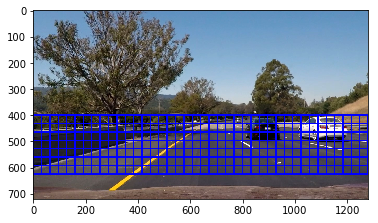

In [21]:
#Let's test it on a image

test_image = cv2.imread("test_images/test6.jpg")
windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[400, 650])              
windows_result = draw_boxes(convertFromCVtoMatlab(test_image), windows, color=(0, 0, 255), thick=3)  
plt.imshow(windows_result)
plt.show()

In [22]:
# Multiple size windows

def slide_window_multiple(img):
    windows_small = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 528],xy_window=(64, 64))
    windows_medium = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 592], xy_window=(96, 96))
    windows_large = slide_window(img, x_start_stop=[None, None], y_start_stop=[336, 720], xy_window=(128, 128)) 
    
    return windows_small + windows_medium + windows_large
    

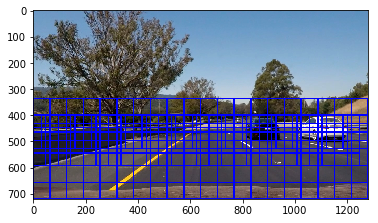

In [23]:
windows_multi = slide_window_multiple(test_image)              
windows_multi_result = draw_boxes(convertFromCVtoMatlab(test_image), windows_multi, color=(0, 0, 255), thick=3)  
plt.imshow(windows_multi_result)
plt.show()


In [24]:
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

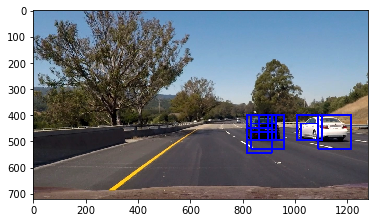

In [25]:
hot_windows = search_windows(test_image, windows_multi, svcmodel, X_Scaler,cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True)                       

search_window_img = draw_boxes(convertFromCVtoMatlab(test_image), hot_windows, color=(0, 0, 255), thick=6)
plt.imshow(search_window_img)
plt.show()

In [26]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    heatmap[heatmap != 0] -= 1
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



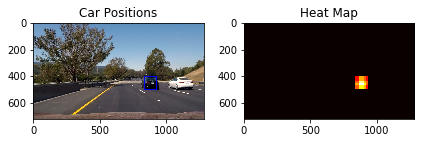

In [27]:
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(convertFromCVtoMatlab(test_image)), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [28]:
# Heatmap filtering

def captureFrames():
    vidcap = cv2.VideoCapture('test_video.mp4')
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
      success,image = vidcap.read()
      cv2.imwrite("frames/frame%d.jpg" % count, image)     # save frame as JPEG file
      count += 1
#captureFrames()

In [35]:
def process_image(img):
    global heat
    global svcmodel
    global X_Scaler
    global video_processing
    
    if (video_processing):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 720],xy_window=(64, 64))
    windows = slide_window_multiple(img)  
    hot_windows = search_windows(img, windows, svcmodel, X_Scaler,cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True)    

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    if (video_processing):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = draw_labeled_bboxes(np.copy(img), labels)
    
    return result

In [36]:
def testOnFrames(frames):
    for frame in frames:
        img = cv2.imread(frame)
        result = process_image(img)
        outputfile = "frames_output/"+frame
        cv2.imwrite(outputfile, result)
    print("Succesfully processed frame images")

frames = glob.glob('frames/*.jpg')

video_processing = False
firstFrame = cv2.imread(frames[0])
heat = np.zeros_like(firstFrame[:,:,0]).astype(np.float)   
testOnFrames(frames)

Succesfully processed frame images


In [37]:
from moviepy.editor import VideoFileClip
project_output = 'project_video_output.mp4'

#Reset heat
heat = np.zeros_like(firstFrame[:,:,0]).astype(np.float) 
print(heat.shape)
video_processing = True
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image)
out_clip.write_videofile(project_output, audio=False)

(720, 1280)
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [20:24<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [38]:
from IPython.display import HTML

HTML("""
<video width="1280" height="720" controls>
  <source src="project_video_output.mp4" type="video/mp4">
</video>
""")